# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Create incomeclasses that are significant

##### Importing Libraries 

In [89]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *
print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [90]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-10000000, 10000, 20000, 40000, 60000, 80000, 90000, 130000, 160000, 240000, 9990000]

# minAge = 55
# maxAge = 64

# minAge = 60
# maxAge = 75

minAge = 65
maxAge = 130

### Setting Directory locations and FileNames on your Local Machine

In [91]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [92]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [93]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [94]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Creating the UCC roll ups for Plynty
##### What is a UCC?
- Universial Classification Code
- Used to classify different expenditure sub categories

In [95]:
# creating UCC rollups for the interview files for plynty categories
iTotalExp = categoricalUCCRollUp(IStub,["TOTALE"])
iFoodAtHome = categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])
iFoodAway = categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])
iHousing = categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))
iUtilites = categoricalUCCRollUp(IStub, ["UTILS"])
iClothingAndBeauty = categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])
iTransportation = categoricalUCCRollUp(IStub, ["TRANS"])
iHealthcare = categoricalUCCRollUp(IStub, ["HEALTH"])
iEntertainment = categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])
iMiscellaneous = categoricalUCCRollUp(IStub, ["MISC","TOBACC"])
iCharitableAndFamilyGiving = categoricalUCCRollUp(IStub, ["CASHCO"])
iInsurance = categoricalUCCRollUp(IStub, ["LIFEIN"])
iEducation = categoricalUCCRollUp(IStub, ["EDUCAT"])
iHousingPrinciple = categoricalUCCRollUp(IStub,["MRTPRI"])

### Adding and Rolling up the MTBI Categories into mtbiRolledUp
##### What is the MTBI file?
- Monthly expenditure file classified by UCC
- Used to populate expenditures in each category for each CU

In [96]:
rollupNames = ["iTotalExp","iFoodAtHome","iFoodAway","iHousing","iUtilites","iClothingAndBeauty","iTransportation","iHealthcare","iEntertainment","iMiscellaneous","iCharitableAndFamilyGiving","iInsurance","iEducation","iHousingPrinciple"]
rollups = [iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple]

# there is a multiple of 4 because each survey lasts for 3 months 
# multiplying by 4 gives a estimate for each year (3 * 4 = 12)
mtbiRolledUp = rollUpDataframe(mtbi, rollupNames, rollups, negativeColumns=["iHousingPrinciple"], multiple=4)

mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating the Sum for all expenditure category columns for each NEWID
- nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [97]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Plotting the total population CU counts

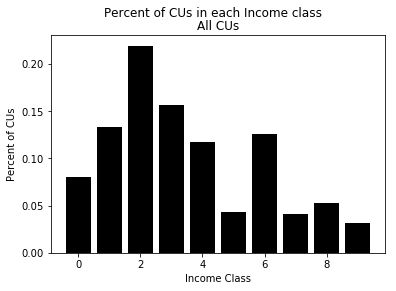

In [98]:
fmliTotalRecoded = binColumn(dataframe=fmli, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(0,len(incomeBrackets)-1))

plt.bar(fmliTotalRecoded.INCLASS.value_counts().index, (fmliTotalRecoded.INCLASS.value_counts().values)/(len(fmliTotalRecoded)), color="black")
plt.suptitle("Percent of CUs in each Income class")
plt.title("All CUs")
plt.xlabel("Income Class")
plt.ylabel("Percent of CUs")
plt.show()

### Subsetting FMLI for age and recoding the incomebrackets
##### What is the fmli file?
- File with entries for each CU, characteristics, and summary level expenditures

In [99]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

### Displaying the number of CUs where the reference person is retired

In [100]:
print("The percent of retired CUs is: "+str(round(len(fmliRecoded.INCNONW1.loc[fmliRecoded.INCNONW1 == 1])/len(fmliRecoded.INCNONW1),3)))

The percent of retired CUs is: 0.717


### Adding the Income class colum to the ExpensesByNewID dataframe

In [101]:
# combining the fmli and iExpensesByNewID
inclassExpenses = pd.merge(left=fmliRecoded[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
# inclassExpenses

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [102]:
# getting mean for all columns with the same income class besides newId and creating new dataframe
inclassAverages = round(inclassExpenses.ix[: ,inclassExpenses.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# inclassAverages

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [103]:
# creating new dataframe for the percentages that only includes the plynty categories
percentages = inclassAverages.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    percentages[column] = inclassAverages[column]/inclassAverages.iTotalExp
percentages['ExpInc'] = inclassAverages['iTotalExp']/inclassAverages['FINCBTXM']

# truncate the max ExpInc
percentages.ExpInc.ix[percentages['ExpInc']>1] = 1

# percentages

# Exploring Issues in the data

### Getting Description of the inclassExpenses dataframe
Description includes:
- count
- mean
- standard deviation
- min
- max
- quartiles

In [104]:
# max and min of housing per income class
rowDescription = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription.append(inclassExpenses.iHousing.loc[inclassExpenses.INCLASS == inclass].describe())
descriptions = pd.concat(rowDescription, axis=1)
descriptions.columns = range(0,len(incomeBrackets)-1)
descriptions = descriptions.transpose()
# descriptions

### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of 
     - Inner Fence: Q3/Q2 +/- (1.5 x IQR)
     - Outer Fence: Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [105]:
# cleaning the inclassExpenses dataframe of outliers
outliers1 = inclassExpenses.copy()


outliers1
innerFence = []
outerFence = []


print("There are "+str(len(inclassExpenses))+" rows before removal of outliers")

for inclass in range(1,len(incomeBrackets)):
    outliers1InClass = outliers1.where(outliers1['INCLASS']==inclass)
    Q1 = outliers1InClass['iHousing'].quantile(0.25)
    Q3 = outliers1InClass['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (1.5 * IQR))].index.tolist())
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (1.5 * IQR))].index.tolist())    
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (3 * IQR))].index.tolist())


clean1 = outliers1.drop(outliers1.index[innerFence])
clean1
clean2 = outliers1.drop(outliers1.index[outerFence])
clean2

print("Removed "+str(len(innerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(innerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

print("Removed "+str(len(outerFence))+ " rows deemed to be out of outer fence")
print("Removed "+str(round(len(outerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

# creating the descriptions for the cleaned outlier dataframe
rowDescription1 = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription1.append(clean1.iHousing.loc[clean1.INCLASS == inclass].describe())
descriptions1 = pd.concat(rowDescription1, axis=1)
descriptions1.columns = range(0,len(incomeBrackets)-1)
descriptions1 = descriptions1.transpose()
# descriptions1

There are 5388 rows before removal of outliers
Removed 356 rows deemed to be out of inner fence
Removed 6.61% of the CUs
Removed 139 rows deemed to be out of outer fence
Removed 2.58% of the CUs


### Looking at the outliers that were removed

In [106]:
innerOutliers = inclassExpenses.copy()
innerOutliers = innerOutliers.ix[innerFence,:]
print("Number of outliers in each income class: "+str(innerOutliers.INCLASS.value_counts().values))
# innerOutliers.head()

Number of outliers in each income class: [116  75  42  38  30  23   9   9   8   6]


In [107]:
outerOutliers = inclassExpenses.copy()
outerOutliers = outerOutliers.ix[outerFence,:]
print("Number of outliers in each income class: "+str(outerOutliers.INCLASS.value_counts().values))
# outerOutliers.head()

Number of outliers in each income class: [41 41 12 11 10 10  6  4  2  2]


### Creating the percentage output for cleaned dataframe
##### What is the percentage dataframe?
- Dataframe where each row is a different income class and each column is a different plynty expenditure category
- These are percents of total expenditure (not of total income)

In [108]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages1 = round(clean1.ix[: ,clean1.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages1 = inclassCleanAverages1.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages1[column] = inclassCleanAverages1[column]/inclassCleanAverages1.iTotalExp
cleanPercentages1['ExpInc'] = inclassCleanAverages1['iTotalExp']/inclassCleanAverages1['FINCBTXM']
# truncate the max ExpInc
cleanPercentages1.ExpInc.ix[cleanPercentages1['ExpInc']>1] = 1
cleanPercentages1

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.142760,0.065465,0.254132,0.108510,0.024735,0.123053,0.152320,0.047408,0.038487,0.055566,0.003810,0.002302,0.018549,1.000000
1,0.143314,0.066238,0.247728,0.122342,0.026799,0.142919,0.140742,0.052440,0.019384,0.046301,0.008811,0.001617,0.018634,1.000000
2,0.129640,0.068219,0.222666,0.105685,0.025402,0.160788,0.169596,0.055769,0.016982,0.054558,0.006266,0.002755,0.018324,1.000000
3,0.117956,0.064125,0.242087,0.096358,0.027847,0.175623,0.158887,0.054669,0.018040,0.064095,0.009448,0.004069,0.033203,0.858669
4,0.114299,0.066555,0.244939,0.088417,0.032277,0.180536,0.149920,0.055787,0.017718,0.069236,0.007503,0.001434,0.028620,0.707340
5,0.105324,0.058105,0.270412,0.086217,0.026344,0.232130,0.136686,0.043984,0.019156,0.047698,0.006830,0.004706,0.037593,0.669466
6,0.097787,0.062204,0.228952,0.078390,0.029445,0.223403,0.116982,0.067968,0.017366,0.090713,0.007848,0.010784,0.031841,0.624104
7,0.093507,0.055416,0.297054,0.081630,0.028474,0.244508,0.110014,0.052942,0.012363,0.060632,0.010715,0.005774,0.053029,0.516418
8,0.089282,0.061733,0.311870,0.076662,0.043746,0.161679,0.100269,0.068941,0.037671,0.076662,0.013307,0.004462,0.046284,0.446058
9,0.079879,0.068931,0.277750,0.048191,0.042180,0.225810,0.071389,0.072249,0.043482,0.063713,0.008644,0.021057,0.023275,0.369579


In [109]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages2 = round(clean2.ix[: ,clean2.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages2 = inclassCleanAverages2.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages2[column] = inclassCleanAverages2[column]/inclassCleanAverages2.iTotalExp
cleanPercentages2['ExpInc'] = inclassCleanAverages2['iTotalExp']/inclassCleanAverages2['FINCBTXM']
# truncate the max ExpInc
cleanPercentages2nonTruncated = cleanPercentages2.copy()
cleanPercentages2.ExpInc.ix[cleanPercentages2['ExpInc']>1] = 1
cleanPercentages2

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.139253,0.066370,0.277292,0.105222,0.024542,0.125901,0.145579,0.051928,0.034306,0.053519,0.003806,0.002037,0.029754,1.000000
1,0.138555,0.065560,0.265309,0.119291,0.026709,0.139425,0.140227,0.051366,0.018510,0.046805,0.008788,0.002002,0.022545,1.000000
2,0.125472,0.067455,0.242334,0.101622,0.025628,0.157339,0.166285,0.054730,0.016363,0.056061,0.005947,0.002694,0.021933,1.000000
3,0.115387,0.065302,0.256925,0.093793,0.028051,0.172176,0.154530,0.054452,0.017448,0.062964,0.008984,0.003812,0.033823,0.886292
4,0.110443,0.065919,0.269419,0.084987,0.030508,0.172025,0.142422,0.053625,0.016571,0.072341,0.008696,0.001403,0.028358,0.737127
5,0.103927,0.058600,0.282201,0.085166,0.026842,0.226787,0.135888,0.046346,0.018662,0.047955,0.006680,0.004541,0.043596,0.679942
6,0.095508,0.062709,0.251259,0.076738,0.028961,0.214949,0.115952,0.066816,0.017183,0.086654,0.007993,0.010082,0.034805,0.638800
7,0.092289,0.055504,0.315647,0.080496,0.028962,0.236860,0.108439,0.052095,0.011957,0.060919,0.010358,0.005605,0.059131,0.524622
8,0.085006,0.059214,0.332893,0.073465,0.041375,0.165735,0.097635,0.066132,0.035281,0.073422,0.012899,0.007107,0.050165,0.462627
9,0.077704,0.068417,0.295647,0.047043,0.040955,0.215340,0.070594,0.071263,0.050712,0.061213,0.008282,0.019562,0.026731,0.381118


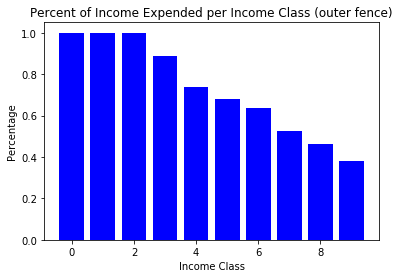

In [110]:
plt.bar(cleanPercentages2.index, cleanPercentages2.ExpInc, color = 'b')
plt.title("Percent of Income Expended per Income Class (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
plt.show()

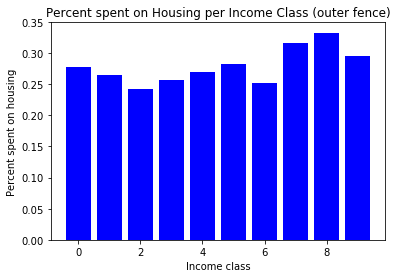

In [111]:
plt.bar(cleanPercentages2.index, cleanPercentages2.iHousing, color = 'b')
plt.title("Percent spent on Housing per Income Class (outer fence)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
plt.show()

# Plots

In [112]:
# ploting the number of people in each bracket
print(inclassExpenses.INCLASS.value_counts().values)
plt.bar(list(inclassExpenses.INCLASS.value_counts().index.tolist()), inclassExpenses.INCLASS.value_counts().values, align='center', color = "r")
plt.title("Number of CUs in Income classes (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1753  958  889  499  452  267  204  157  125   84]


In [113]:
# creating the plot of percent of income expended per income class
plt.bar(percentages.index, percentages.ExpInc, color = 'r')
plt.title("Percent of Income Expended per Income Class (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [114]:
# creating plot of Percent spent on Housing per income class
plt.bar(percentages.index, percentages.iHousing, color = 'r')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (with outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

In [115]:
inclassSD = inclassExpenses.groupby(['INCLASS'],as_index=False).std()
inclassSD.iHousing
plt.bar(inclassSD.iHousing.index, inclassSD.iHousing, color = 'r')
plt.title("Standard deviations in Income Classes (with outliers)")
plt.ylim(0,60000)
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [116]:
# ploting the number of people in each bracket
print(clean1.INCLASS.value_counts().values)
plt.bar(list(clean1.INCLASS.value_counts().index.tolist()), clean1.INCLASS.value_counts().values, align='center', color="g")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1637  883  847  461  422  244  196  148  119   75]


In [117]:
inclassClean1SD = clean1.groupby(['INCLASS'],as_index=False).std()
inclassClean1SD.iHousing
plt.bar(inclassClean1SD.iHousing.index, inclassClean1SD.iHousing,color = 'g')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (inner fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [118]:
# ploting the number of people in each bracket
print(clean2.INCLASS.value_counts().values)
plt.bar(list(clean2.INCLASS.value_counts().index.tolist()), clean2.INCLASS.value_counts().values, align='center', color="b")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1712  917  877  489  441  257  200  155  123   78]


In [119]:
inclassClean2SD = clean2.groupby(['INCLASS'],as_index=False).std()
inclassClean2SD.iHousing
plt.bar(inclassClean2SD.iHousing.index, inclassClean2SD.iHousing,color = 'b')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

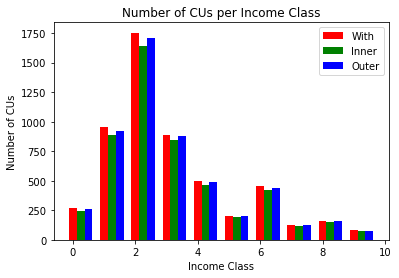

array([1712,  917,  877,  489,  441,  257,  200,  155,  123,   78])

In [120]:
plt.close()
n_groups = 4
values1 = inclassExpenses.INCLASS.value_counts().values
values2 = clean1.INCLASS.value_counts().values
values3 = clean2.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(inclassExpenses.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(clean1.INCLASS.value_counts().index -1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(clean2.INCLASS.value_counts().index - 1 + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()
clean2.INCLASS.value_counts().values

The average percent change between with and without outliers: 2.23%


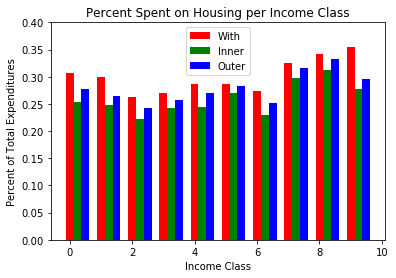

In [121]:
n_groups = 4
values1 = percentages.iHousing
values2 = cleanPercentages1.iHousing
values3 = cleanPercentages2.iHousing

print("The average percent change between with and without outliers: "+str(round((values1-values3).mean()*100,2))+"%")

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.ylim(0,.4)
plt.legend()
plt.show()

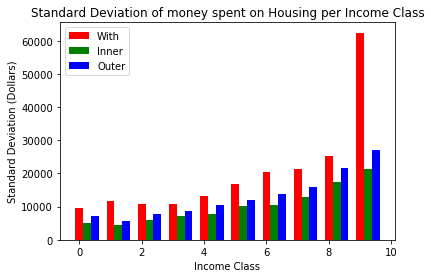

In [122]:
n_groups = 4
values1 = inclassSD.iHousing
values2 = inclassClean1SD.iHousing
values3 = inclassClean2SD.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Standard Deviation (Dollars)')
plt.title('Standard Deviation of money spent on Housing per Income Class')
plt.legend()
plt.show()

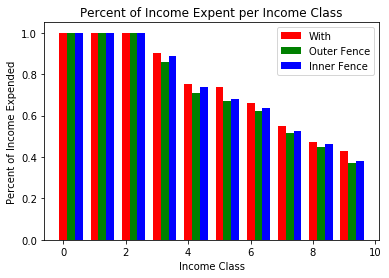

In [123]:
n_groups = 3
values1 = percentages.ExpInc
values2 = cleanPercentages1.ExpInc
values3 = cleanPercentages2.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Outer Fence')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Inner Fence')
 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

# Least squares polynomial fit
any value that would cause a person to expend over 100% of their income is truncated to 100%

           3             2
6.635e-13 x - 7.694e-07 x + 0.4993 x + 2.054e+04


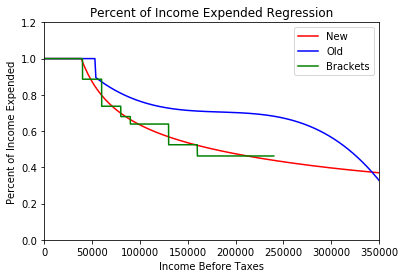

In [124]:
# cleanPercentages2.ExpInc[3:]
cleanReg = clean2[["FINCBTXM","iTotalExp"]]
cleanReg = cleanReg.loc[clean2.FINCBTXM > 0]
cleanReg = cleanReg.loc[cleanReg.iTotalExp > 0]
cleanReg
def getExpendPercent(income):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    return(percent)

def printRegression():
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    print(p)
    
    
printRegression()
    
x = range(0,360000,1000)
x2 = range(0,360000,1000)
y =[]
y2 =[]
def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)


for bracket in range(0,360000,1000):
    y.append(getExpendPercent(bracket))
    y2.append(oldRegression(bracket))
# plt.plot(inclassCleanAverages2.FINCBTXM,cleanPercentages2.ExpInc)
plt.plot(x,y, color = "r", label="New")
plt.plot(x2,y2, color = "b", label = "Old")
x3 = range(0,incomeBrackets[len(incomeBrackets)-2])

# creating the repeatArray for income Bracket plotting
lastvalue = 0
repeatArray = []
for x in range(0,len(incomeBrackets[1:len(incomeBrackets)-1])):
    repeatArray.append(incomeBrackets[1:len(incomeBrackets)-1][x] - lastvalue)
    lastvalue = incomeBrackets[1:len(incomeBrackets)-1][x]

y3 = np.repeat(cleanPercentages2.ExpInc[0:len(cleanPercentages2)-1], repeatArray)
plt.plot(x3,y3, color = "g", label = "Brackets")
plt.title("Percent of Income Expended Regression")
plt.xlabel("Income Before Taxes")
plt.ylabel("Percent of Income Expended")
plt.xlim(0,350000)
plt.ylim(0,1.2)
plt.legend()
plt.show()

### Plot of number of CUs for clean2 only

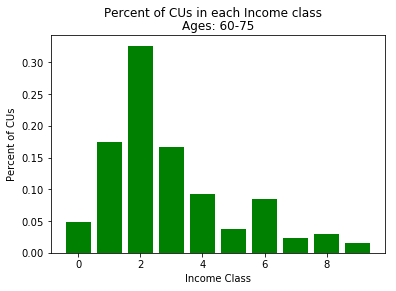

In [125]:
plt.bar(clean2.INCLASS.value_counts().index - 1, (clean2.INCLASS.value_counts().values)/(len(clean2)), alpha=opacity, color='g')
plt.suptitle("Percent of CUs in each Income class")
plt.title("Ages: 60-75")
plt.xlabel("Income Class")
plt.ylabel("Percent of CUs")
plt.show()

# Examples of Users

In [126]:
usersIncome = [30000, 60000, 90000, 120000, 250000]
def getIncomeBracket(income):
    for bracket in range(len(incomeBrackets)-2,0,-1):
        if income > incomeBrackets[bracket]:
            return bracket
            

exampleExpenses = pd.DataFrame(columns = cleanPercentages2.columns, index = range(len(usersIncome)))
for user in usersIncome:
    userBracket = getIncomeBracket(user)
    userExpendAmount = getExpendPercent(user) * user
    userBaseExpenses = (cleanPercentages2.loc[userBracket]*userExpendAmount)/12
    exampleExpenses.loc[usersIncome.index(user)] = userBaseExpenses

exampleExpenses.index = usersIncome

exampleExpenses

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
30000,313.681,168.639,605.836,254.056,64.0689,393.346,415.712,136.826,40.9087,140.153,14.8687,6.736,54.8324,2500
60000,460.266,260.482,1024.85,374.13,111.892,686.793,616.403,217.204,69.5977,251.158,35.8371,15.2046,134.917,3535.33
90000,517.238,291.648,1404.49,423.862,133.589,1128.7,676.304,230.658,92.8798,238.67,33.2438,22.6003,216.972,3384.01
120000,561.241,368.501,1476.49,450.94,170.188,1263.12,681.38,392.638,100.973,509.214,46.9727,59.2457,204.525,3753.83
250000,696.959,613.665,2651.78,421.944,367.339,1931.47,633.188,639.186,454.854,549.04,74.2841,175.457,239.758,3418.4


# Creating CSV fo percentages

In [127]:
cleanPercentages2.to_csv("percentage"+str(minAge)+"to"+str(maxAge)+".csv")

# Importing CSVs of pre-Subset Percentages CSVs

In [134]:
ageRange1 = pd.read_csv("percentage55to64.csv", index_col=0)
ageRange2 = pd.read_csv("percentage60to75.csv", index_col=0)
ageRange3 = pd.read_csv("percentage65to130.csv", index_col=0)

### Plotting the differences between Age brackets

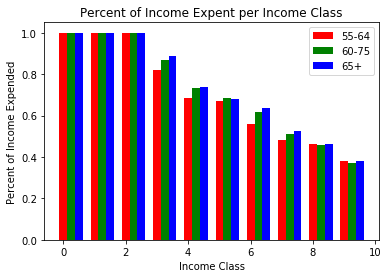

In [135]:
n_groups = 3
values1 = ageRange1.ExpInc
values2 = ageRange2.ExpInc
values3 = ageRange3.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

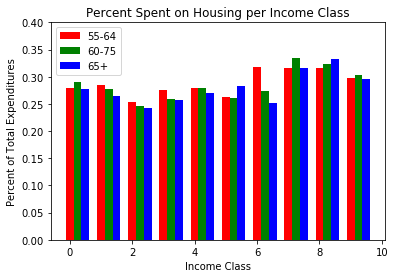

In [139]:
n_groups = 3
values1 = ageRange1.iHousing
values2 = ageRange2.iHousing
values3 = ageRange3.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.legend()
plt.ylim(0,.4)
plt.show()

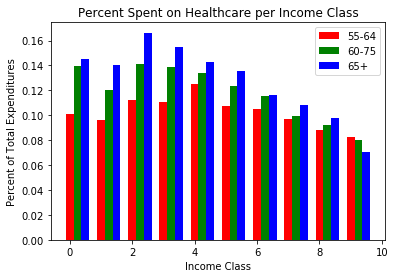

In [137]:
n_groups = 3
values1 = ageRange1.iHealthcare
values2 = ageRange2.iHealthcare
values3 = ageRange3.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Healthcare per Income Class')
plt.legend()
plt.show()

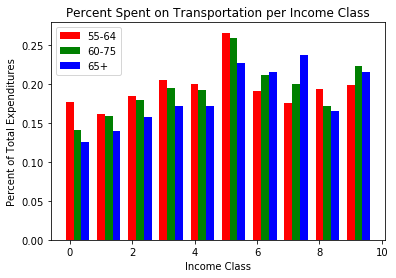

In [138]:
n_groups = 2
values1 = ageRange1.iTransportation
values2 = ageRange2.iTransportation
values3 = ageRange3.iTransportation

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Transportation per Income Class')
plt.legend()
plt.show()

# Thoughts on the difference between 55-64, 60-75, and 65+
- On average: 55-64 < 60-75 < 65+ in terms of expenditure percentage

## What each bracket represents
- 55-64 simulates that specific time right before and right at the begining of retirment
- 60-75 simulates the time during retirement with some non-retired CUs
- 65+ is a higher potential to show people who have actually retired